In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.stats import BoxLeastSquares

import pymc3 as pm
import theano.tensor as tt
from exoplanet.theano_ops import kepler, starry, celerite
from exoplanet.distributions import Angle

In [3]:
def get_pimen_data():
    # Download the RV dataset from the Exoplanet Archive:
    url = "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0026/0026394/data/UID_0026394_RVC_001.tbl"
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    data = np.array([l.split() for l in r.text.splitlines()
                     if not l.startswith("\\") and not l.startswith("|")],
                    dtype=float)
    t, rv, rv_err = data.T
    t -= np.mean(t)

    # Plot the observations "folded" on the published period:
    lit_period = 2091.2
    
    plt.plot()
    plt.errorbar(t, rv, yerr=rv_err, fmt=".k", capsize=0)
    # plt.xlim(0, 1)
    plt.ylim(-110, 110)
    plt.ylabel("radial velocity [m/s]")
    plt.xlabel("phase");
    
    tpf_url = "https://archive.stsci.edu/hlsps/tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00261136679-s01_tess_v1_tp.fits"
    with fits.open(tpf_url) as hdus:
        tpf = hdus[1].data
        tpf_hdr = hdus[1].header
        tpf_mask = hdus[2].data
        
    lc_url = "https://archive.stsci.edu/hlsps/tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00261136679-s01_tess_v1_lc.fits"
    with fits.open(lc_url) as hdus:
        lc = hdus[1].data
        lc_hdr = hdus[1].header
        
    return (t, rv, rv_err), (tpf, tpf_hdr, tpf_mask), (lc, lc_hdr)

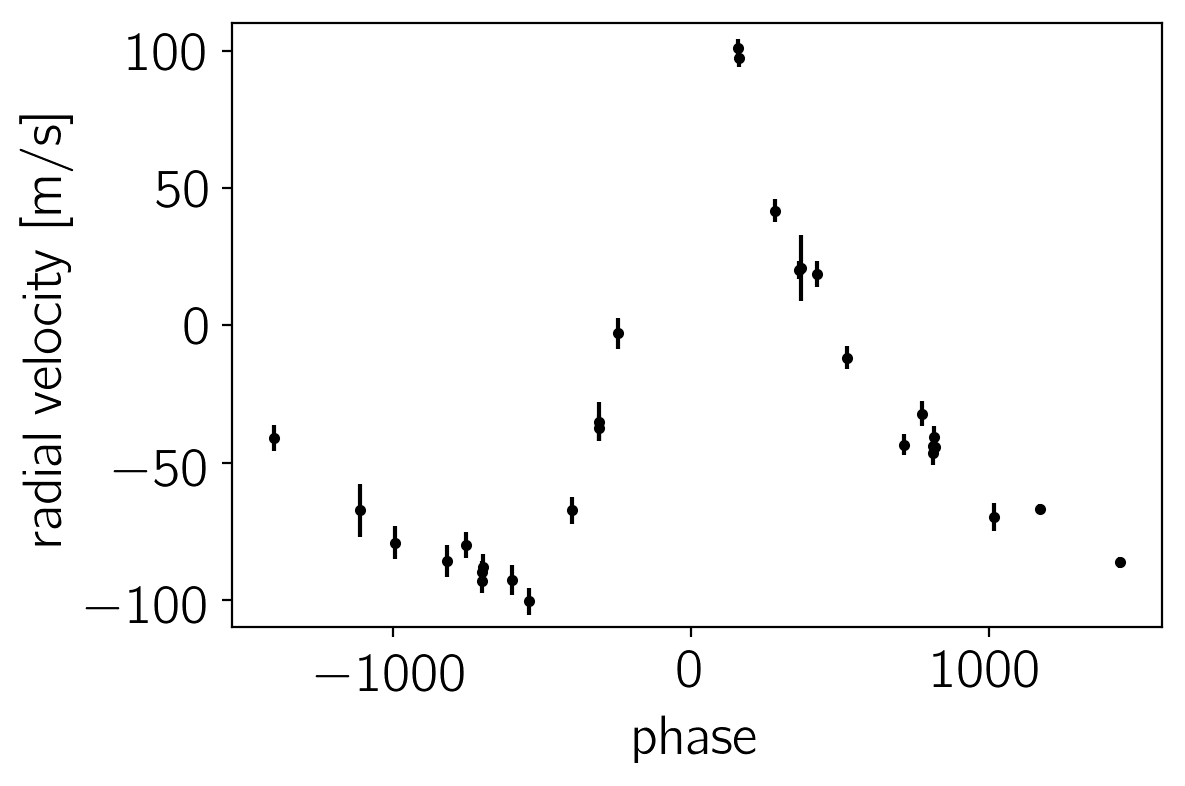

In [4]:
(t, rv, rv_err), (tpf, tpf_hdr, tpf_mask), (lc, lc_hdr) = get_pimen_data()

In [5]:
m = (lc["QUALITY"] == 0) & np.isfinite(lc["PDCSAP_FLUX"]) & np.isfinite(lc["TIME"])

x = lc["TIME"][m]
y = lc["PDCSAP_FLUX"][m]
mu = np.median(y)
y = y / mu - 1
yerr = lc["PDCSAP_FLUX_ERR"][m] / mu

# Initial PLD model + sigma clipping
X_pld = np.reshape(tpf["FLUX"][:, tpf_mask == 267], (len(tpf), -1))[m, :] / lc["PDCSAP_FLUX"][m, None]
X_pld = np.concatenate((X_pld, np.ones((len(X_pld), 1))), axis=1)

# Sigma clipping
m_new = np.ones(len(X_pld), dtype=bool)
for i in range(10):
    w_pld = np.linalg.solve(np.dot(X_pld[m_new].T, X_pld[m_new]),
                            np.dot(X_pld[m_new].T, y[m_new]))
    pld_mod = np.dot(X_pld, w_pld)
    resid = np.abs(y - pld_mod)
    sigma = np.sqrt(np.mean(resid**2))
    m_update = resid < 3 * sigma
    if m_update.sum() == m_new.sum():
        m_new = m_update
        break
    m_new = m_update
    
x = np.ascontiguousarray(x[m_new], dtype=np.float64)
x -= np.min(x)
y = np.ascontiguousarray(y[m_new], dtype=np.float64)
yerr = np.ascontiguousarray(yerr[m_new], dtype=np.float64)
X_pld = np.ascontiguousarray(X_pld[m_new], dtype=np.float64)
pld_mod = np.ascontiguousarray(pld_mod[m_new], dtype=np.float64)

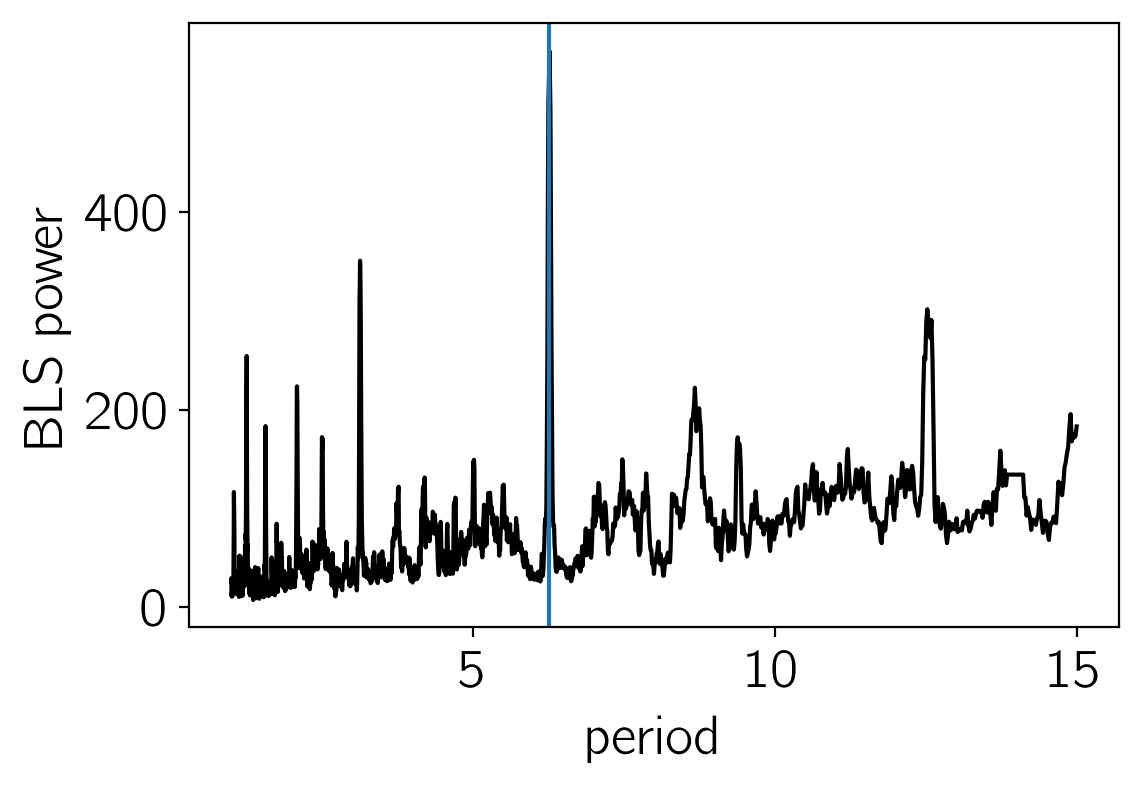

In [6]:
bls_model = BoxLeastSquares(x, y - pld_mod, yerr)
periods = np.exp(np.linspace(np.log(1), np.log(15), 2000))
results = bls_model.power(periods, 0.05)

ind = np.argmax(results.power)
period_guess = results.period[ind]
t0_guess = results.transit_time[ind]
depth_guess = results.depth[ind]

plt.plot(results.period, results.power, "k")
plt.axvline(period_guess)
plt.ylabel("BLS power")
plt.xlabel("period");

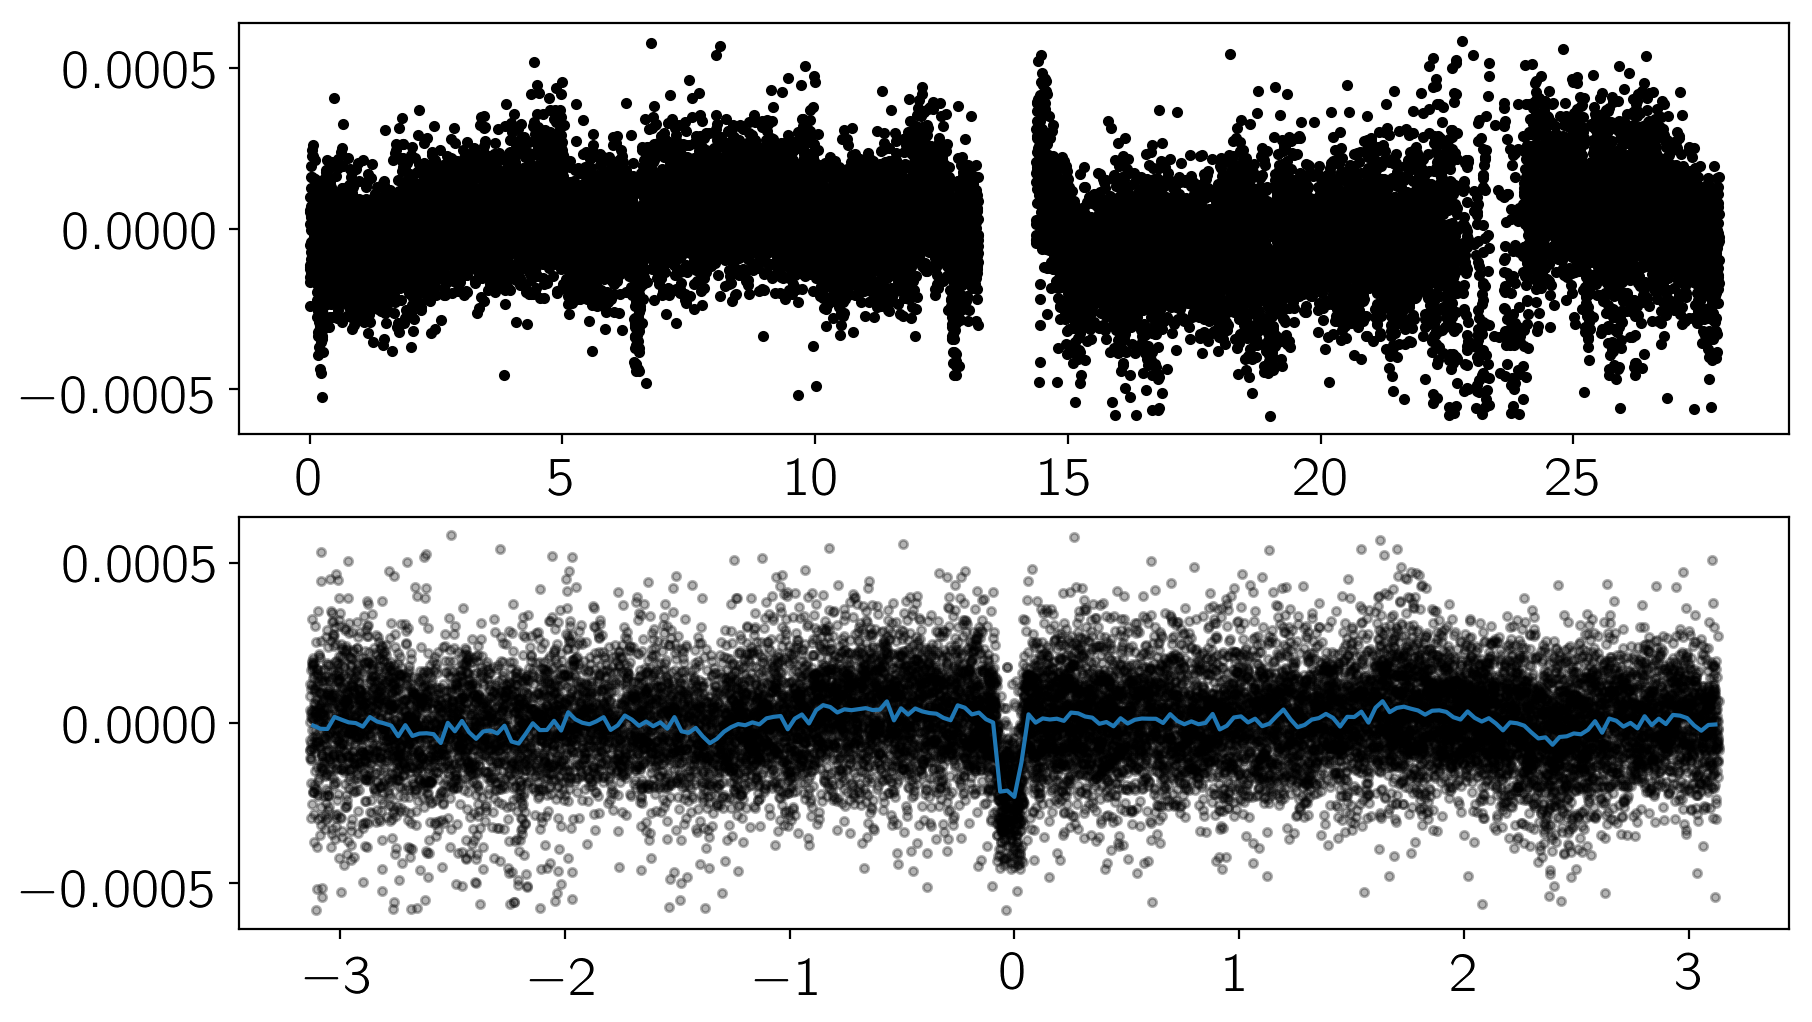

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

ax = axes[0]
ax.plot(x, y - pld_mod, ".k")

x_fold = (x - t0_guess + 0.5*period_guess) % period_guess - 0.5*period_guess
bins = np.linspace(-0.5*period_guess, 0.5*period_guess, 200)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y - pld_mod)

ax = axes[1]
ax.plot(x_fold, y - pld_mod, ".k", alpha=0.3)
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom);

In [8]:
m_near = np.abs(x_fold) < 0.5
x = np.ascontiguousarray(x[m_near], dtype=np.float64)
y = np.ascontiguousarray(y[m_near], dtype=np.float64)
yerr = np.ascontiguousarray(yerr[m_near], dtype=np.float64)
X_pld = np.ascontiguousarray(X_pld[m_near], dtype=np.float64)
pld_mod = np.ascontiguousarray(pld_mod[m_near], dtype=np.float64)

In [9]:
y_fit = (y - pld_mod) * 1e3
yerr_fit = yerr * 1e3

In [10]:
oversample = 3
oversample = oversample + oversample % 2
dt = 2.0 / 60.0 / 60.0 / 24.0 * np.linspace(-0.5, 0.5, oversample)
stencil = np.ones(oversample)
stencil[1:-1:2] = 4
stencil[2:-1:2] = 2
stencil /= np.sum(stencil)
tgrid = x[:, None] + dt[None, :]

In [11]:
G_cm3_gm1_sm2 = 6.674e-8
G_cm3_gm1_dm2 = G_cm3_gm1_sm2 * (60.0 * 60.0 * 24.0)**2

with pm.Model() as model:
    
    # Limb darkening
    q = pm.Uniform("q", lower=0.0, upper=1.0, shape=(2,),
                   testval=np.array([0.5, 0.5]))
    u = tt.stack([
        2.0 * tt.sqrt(q[0]) * q[1],
        tt.sqrt(q[0]) * (1.0 - 2.0 * q[1]),
    ])
    pm.Deterministic("u", u)

    # Stellar density
    rho = pm.Normal("rho", mu=1.148, sd=0.065, testval=1.148)

    # Mean stellar flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.0)
    
    # Orbit parameters
    logporb = pm.Normal("logporb",
                        mu=np.log(period_guess),
                        sd=1.0,
                        testval=np.log(period_guess))
    t0 = pm.Uniform("t0", lower=t0_guess-0.1, upper=t0_guess+0.1, testval=t0_guess)
    b = pm.Uniform("b", lower=0.0, upper=2.0, testval=0.6)
    logr = pm.Uniform("logr", lower=np.log(0.01), upper=np.log(0.1),
                          testval=0.5*np.log(depth_guess))
    ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, testval=0.01)
    w = Angle("w", testval=0.0)
    
    # Derived orbital parameters
    a = (G_cm3_gm1_dm2 * rho * tt.exp(2*logporb) / (3*np.pi))**(1./3)
    pm.Deterministic("a", a)
    porb = pm.Deterministic("porb", tt.exp(logporb))
    ror = pm.Deterministic("ror", tt.exp(logr))
    incl = pm.Deterministic("incl", tt.arccos(b / a))
#     w = pm.Deterministic("w", tt.arctan2(wvec[1], wvec[0]))
    
    # Solve Kepler's equation and get the sky coordinates
    coords = a * kepler.get_sky_coords(porb, t0, ecc, w, incl, tgrid)
    pm.Deterministic("coords", coords)
    rsky = tt.sqrt(tt.sum(coords[:2]**2, axis=0))
    rsky = tt.switch(coords[2] > 0, rsky, 100 * tt.ones_like(rsky))

    # Compute the transit model
    transit = starry.light_curve(u, rsky, ror + tt.zeros_like(rsky))
    transit = (tt.sum(stencil[None, :] * transit, axis=1) - 1.0) * 1e3 - mean
    pm.Deterministic("transit", transit)
        
    # Likelihood
    logs2 = pm.Uniform("logs2", lower=-20, upper=0, testval=2*np.log(np.median(yerr_fit)))
#     pm.Normal("obs", mu=transit, sd=tt.sqrt(yerr**2 + tt.exp(logs2)), observed=y_fit)
    
    resid = y_fit - transit
    logS0 = pm.Uniform("logS0", lower=-20, upper=0, testval=np.log(np.var(y_fit)))
    logw0 = pm.Uniform("logw0", lower=np.log(2*np.pi/30.0), upper=np.log(2*np.pi/1.0),
                       testval=np.log(2*np.pi/5.0))
#     logQ = pm.Uniform("logQ", lower=-0.5*np.log(2), upper=5.0, testval=1.0)
    kernel = celerite.terms.SHOTerm(S0=tt.exp(logS0), w0=tt.exp(logw0), Q=1/np.sqrt(2))
    
    gp = celerite.GP(kernel, x, yerr**2 + tt.exp(logs2), J=2)
    pm.Potential("obs", gp.log_likelihood(resid))
    
    pm.Deterministic("gp", gp.predict())
    
    soln = pm.find_MAP(start=model.test_point)

logp = 2,001.8, ||grad|| = 86.046: 100%|██████████| 124/124 [00:01<00:00, 107.41it/s]


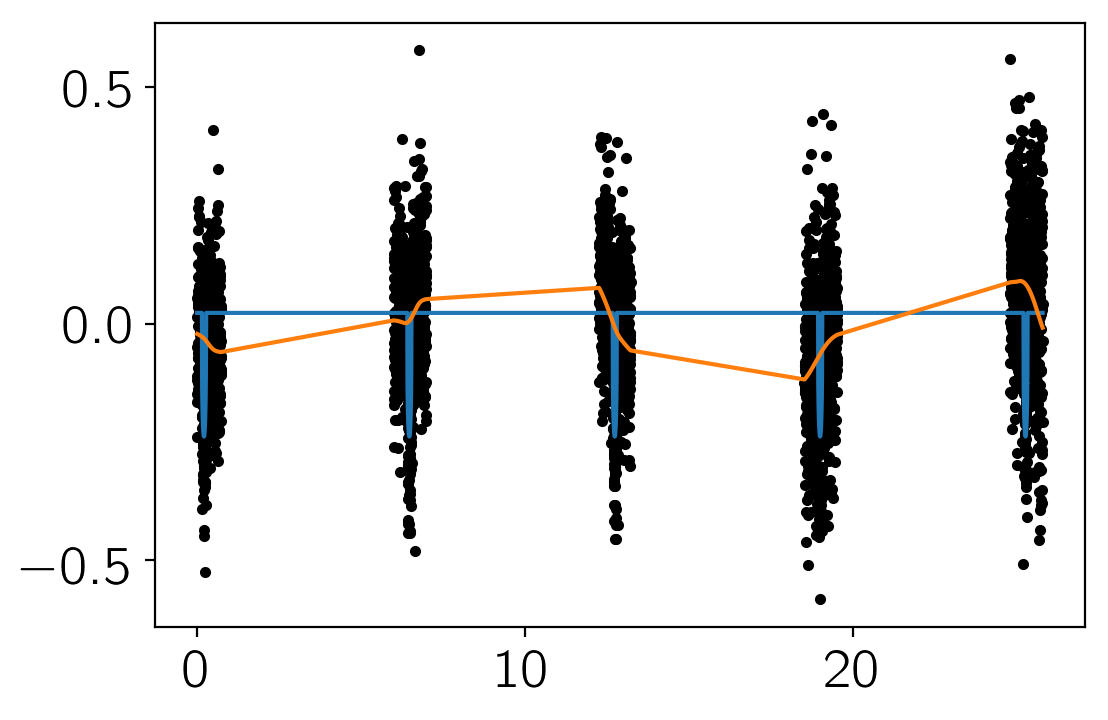

In [12]:
plt.plot(x, y_fit, ".k")
plt.plot(x, soln["transit"])
plt.plot(x, soln["gp"])

In [13]:
n_start = 100
n_burn = 100
n_tune = 1000
n_window = n_start * 2 ** np.arange(np.floor(np.log2((n_tune - n_burn) / n_start)))
last = n_tune - n_burn - np.sum(n_window)
if last < n_window[-1]:
    n_window[-1] += last
else:
    n_window = np.append(n_window, last)
n_window = n_window.astype(int)
print(n_window)

[100 200 600]


In [14]:
from pymc3.step_methods.hmc.quadpotential import QuadPotentialFull

def get_step_for_trace(trace=None, model=None,
                       regular_window=5, regular_variance=1e-3,
                       **kwargs):
    model = pm.modelcontext(model)
    
    # If not given, use the trivial metric
    if trace is None:
        potential = QuadPotentialFull(np.eye(model.ndim))
        return pm.NUTS(potential=potential, **kwargs)
        
    # Loop over samples and convert to the relevant parameter space;
    # I'm sure that there's an easier way to do this, but I don't know
    # how to make something work in general...
    samples = np.empty((len(trace) * trace.nchains, model.ndim))
    i = 0
    for chain in trace._straces.values():
        for p in chain:
            samples[i] = model.bijection.map(p)
            i += 1
    
    # Compute the sample covariance
    cov = np.cov(samples, rowvar=0)
    
    # Stan uses a regularized estimator for the covariance matrix to
    # be less sensitive to numerical issues for large parameter spaces.
    # In the test case for this blog post, this isn't necessary and it
    # actually makes the performance worse so I'll disable it, but I
    # wanted to include the implementation here for completeness
    N = len(samples)
    cov = cov * N / (N + regular_window)
    cov[np.diag_indices_from(cov)] += \
        regular_variance * regular_window / (N + regular_window)
    
    # Use the sample covariance as the inverse metric
    potential = QuadPotentialFull(cov)
    return pm.NUTS(potential=potential, **kwargs)

In [15]:
with model:
    start = soln
    burnin_trace = None
    for steps in n_window:
        step = get_step_for_trace(burnin_trace)
        burnin_trace = pm.sample(
            start=start, tune=steps, draws=2, step=step,
            compute_convergence_checks=False, discard_tuned_samples=False)
        start = [t[-1] for t in burnin_trace._straces.values()]

Only 2 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logw0, logS0, logs2, w, ecc, logr, b, t0, logporb, mean, rho, q]
Sampling 2 chains: 100%|██████████| 204/204 [02:07<00:00,  1.74s/draws]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only 2 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logw0, logS0, logs2, w, ecc, logr, b, t0, logporb, mean, rho, q]
Sampling 2 chains: 100%|██████████| 404/404 [04:32<00:00,  2.27s/draws]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only 2 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logw0, logS0, logs2, w, ecc, logr, b, t0, logporb, mean, rho, q]
Samp

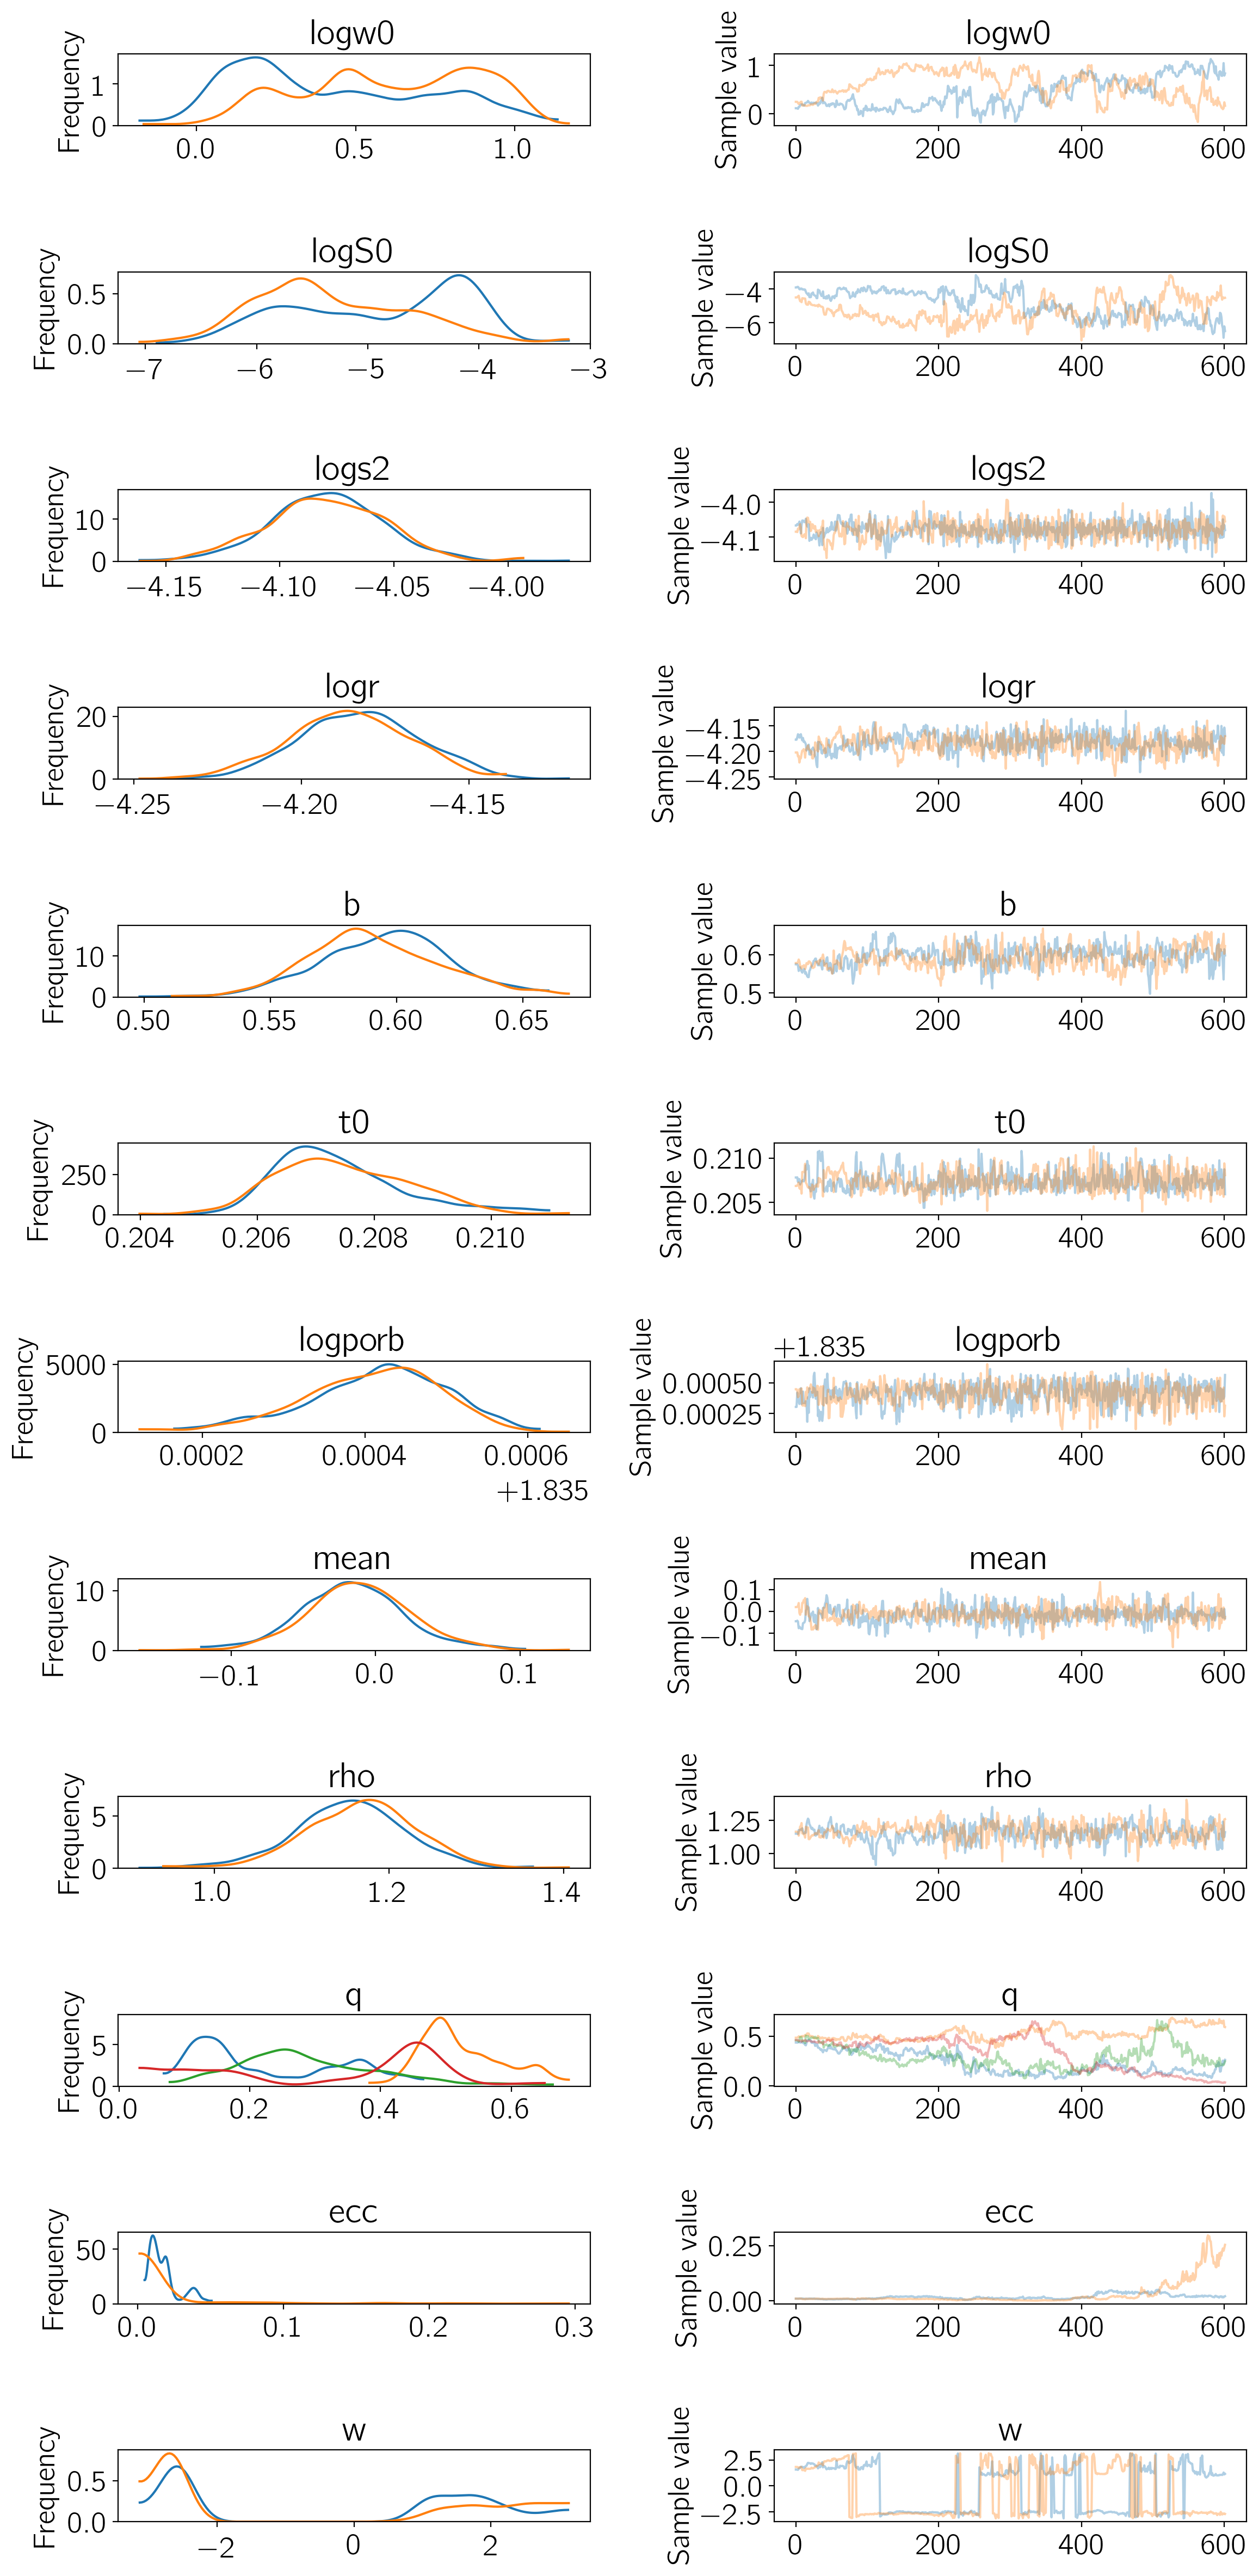

In [26]:
pm.traceplot(burnin_trace, varnames=["logw0", "logS0", "logs2", "logr", "b", "t0", "logporb", "mean", "rho", "q", "ecc", "w"]);

In [17]:
with model:
    step = get_step_for_trace(burnin_trace)
    trace = pm.sample(draws=500, tune=n_burn, step=step, start=start)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logw0, logS0, logs2, w, ecc, logr, b, t0, logporb, mean, rho, q]
Sampling 2 chains: 100%|██████████| 1200/1200 [42:29<00:00,  3.88s/draws]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5024931947956185, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9221795772511987, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


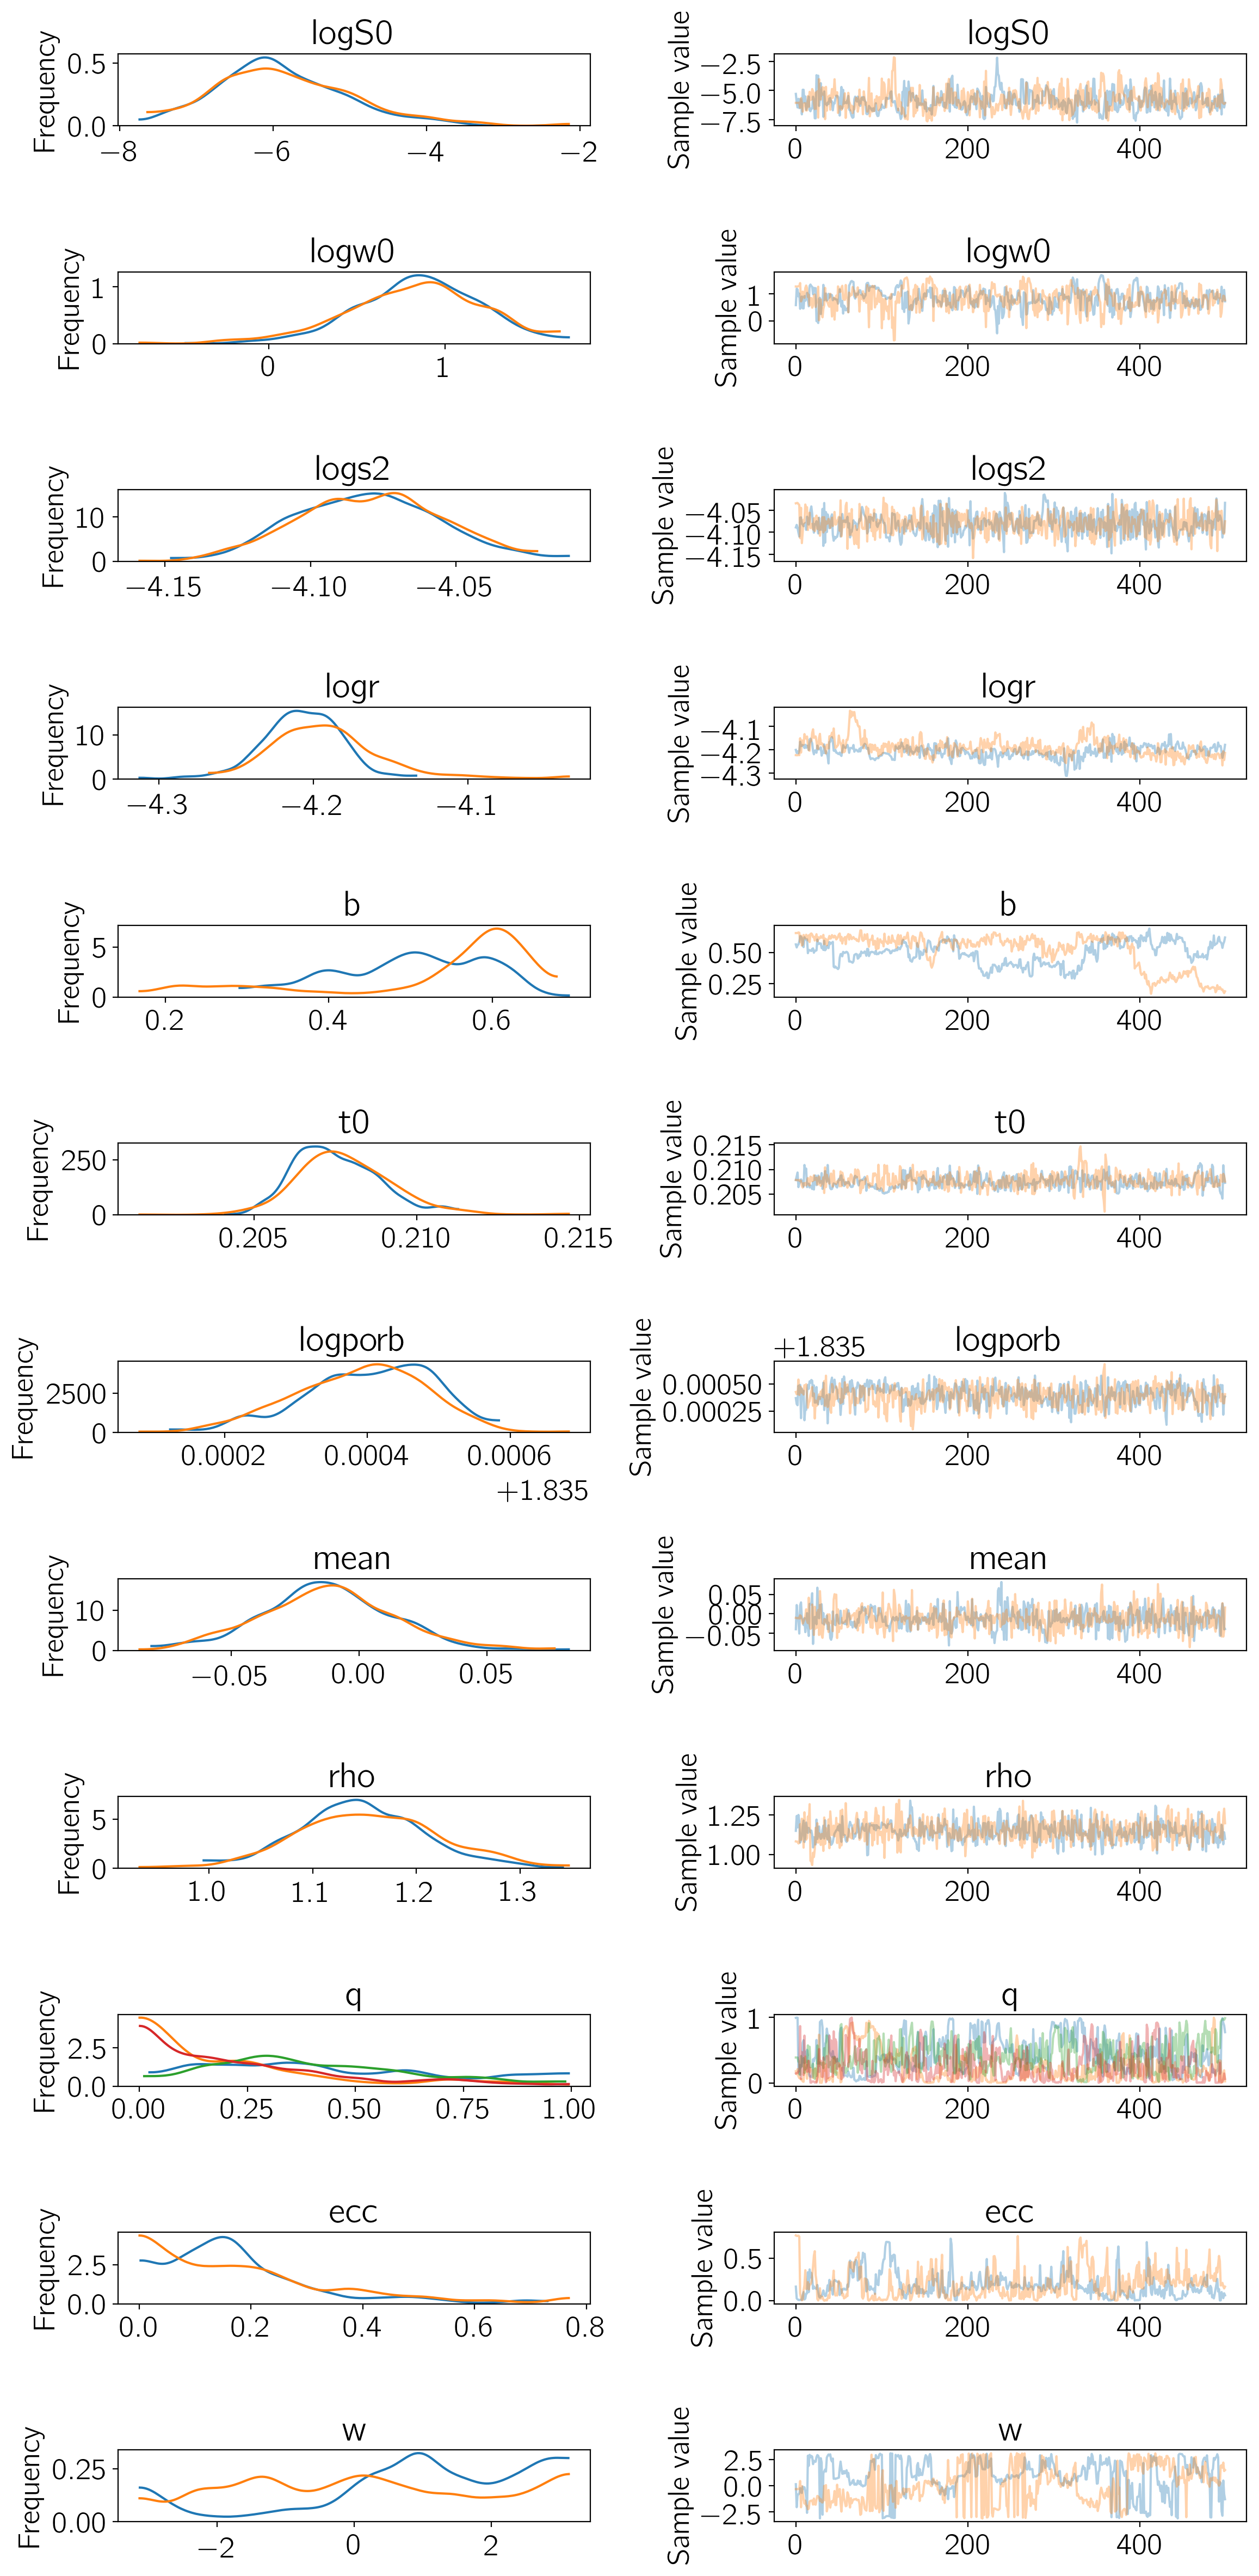

In [19]:
pm.traceplot(trace, varnames=["logS0", "logw0", "logs2", "logr", "b", "t0", "logporb", "mean", "rho", "q", "ecc", "w"]);

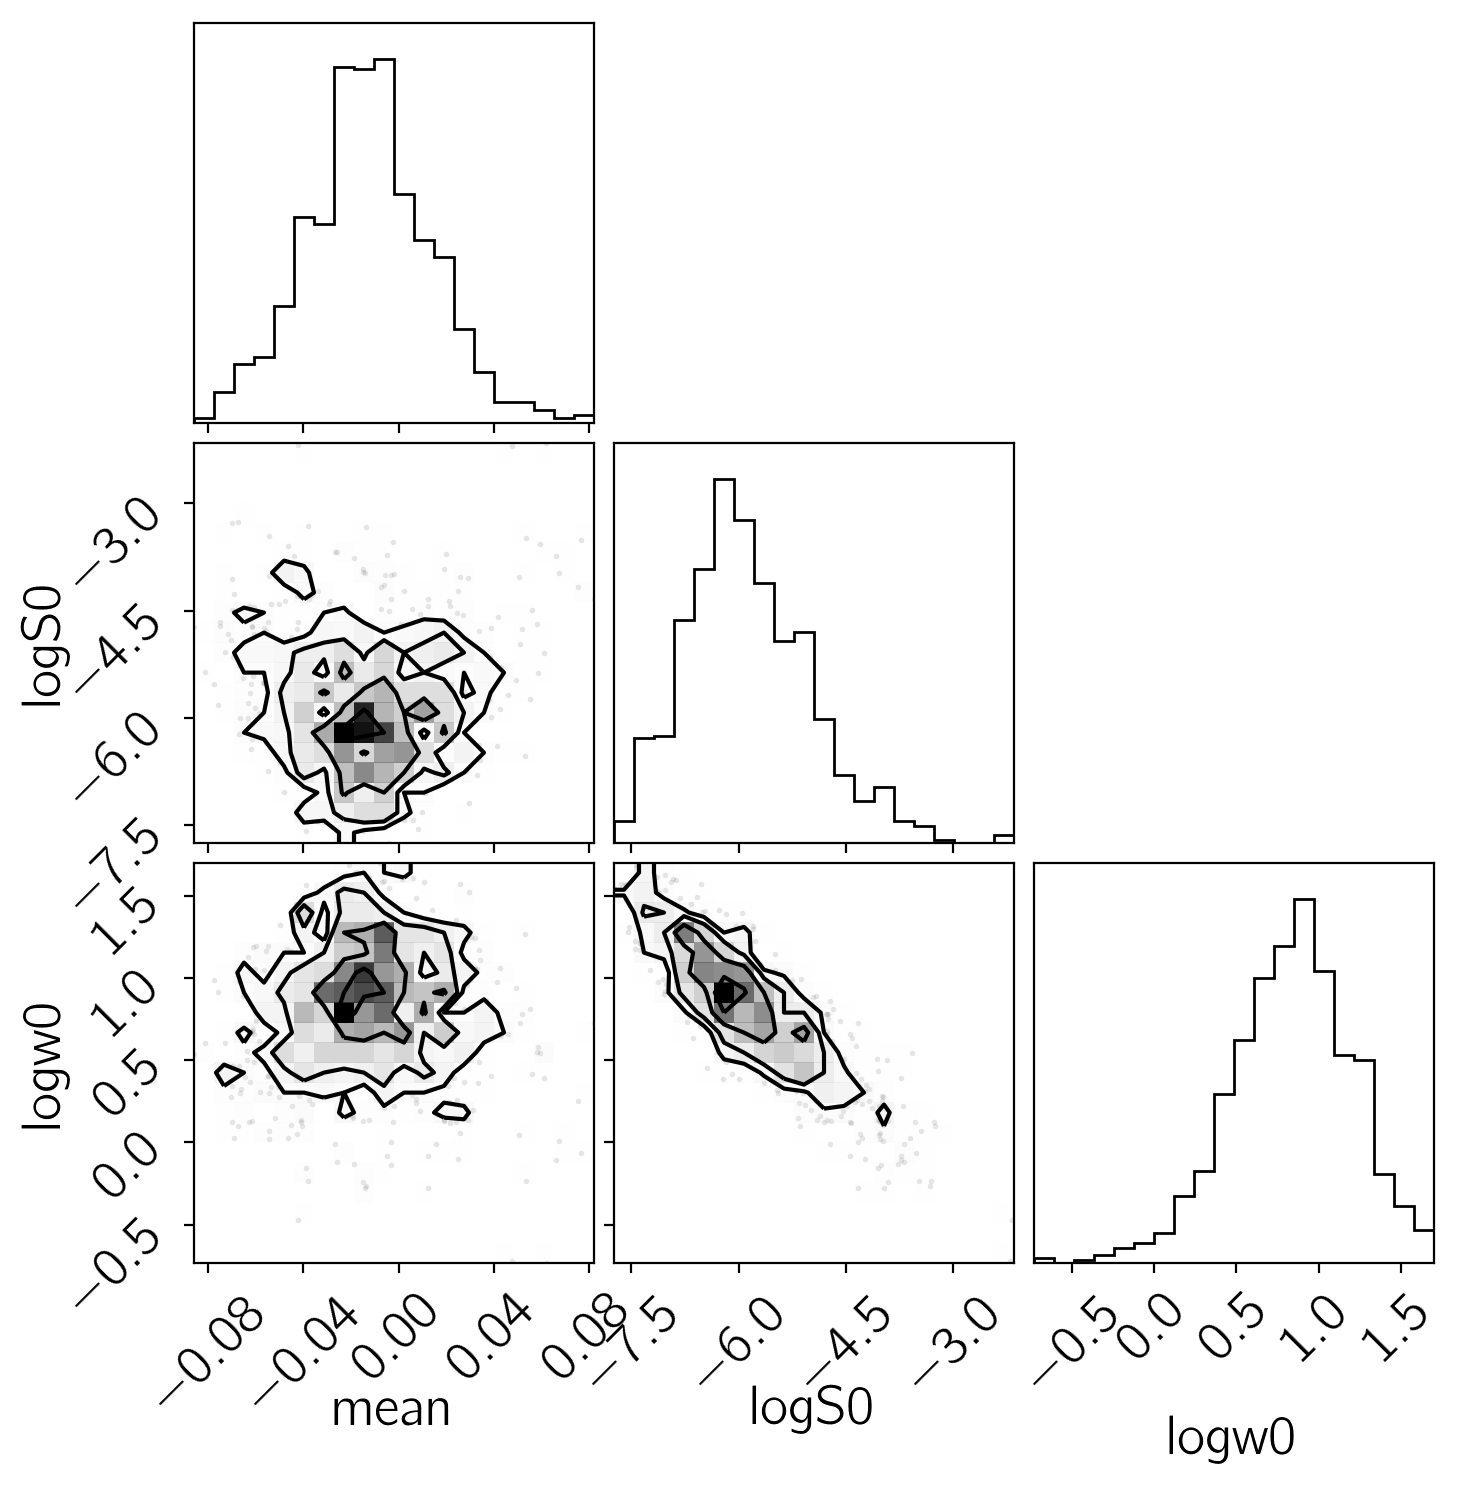

In [31]:
import corner
df = pm.trace_to_dataframe(trace, varnames=["mean", "logS0", "logw0"])
corner.corner(df);

(5.8, 7.2)

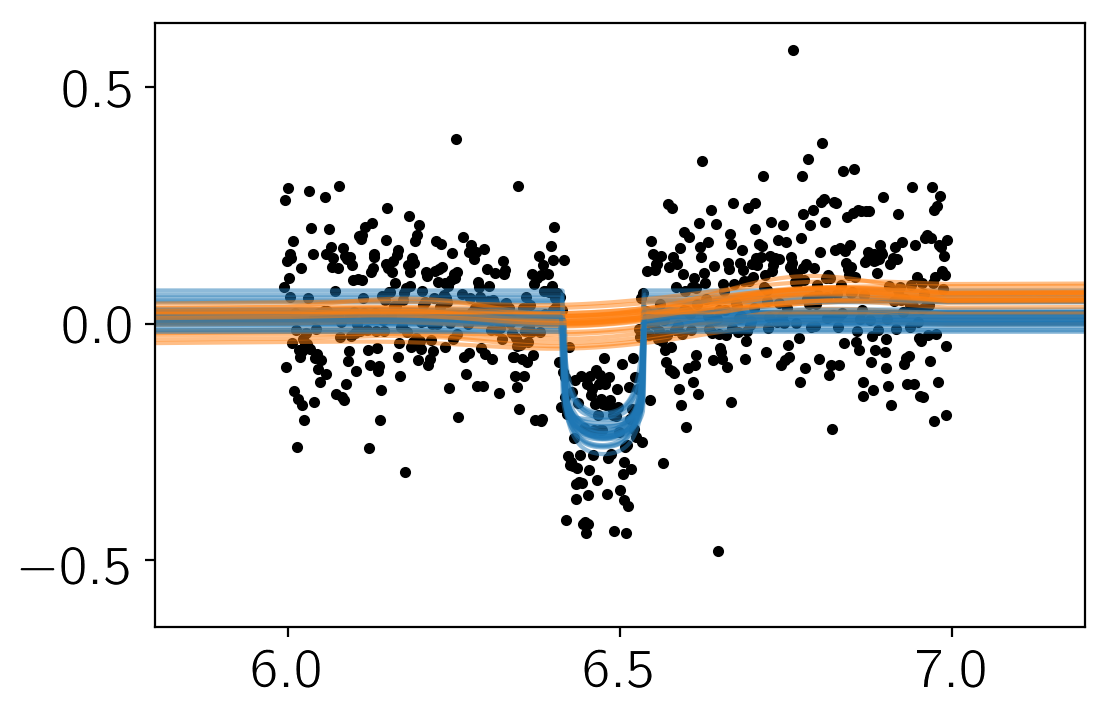

In [34]:
plt.plot(x, y_fit, ".k")

for i in np.random.randint(len(trace) * trace.nchains, size=25):
    plt.plot(x, trace["transit"][i], color="C0", alpha=0.5)
    plt.plot(x, trace["gp"][i], color="C1", alpha=0.5)
plt.xlim(5.8, 7.2)